# Sequentially Testing the Exchangeability of High-Volatility Days for Stock Prices


Given a sequence of stock prices $Y_1, Y_2, ...$, we define the daily volatility as
$$
    V_t = |R_t|, \quad \text{where} \quad R_t = \log Y_t - \log Y_{t-1}.
$$
A _high-volatility day_ is a day where the daily volatility is above a certain threshold:
$$
    H_t = \mathbb{1}(V_t > c),
$$
for some threshold $c$.

We are interested in testing the exchangeability of high-volatility days. That is, we want to test whether the high-volatility days are randomly distributed in the sequence of stock prices. We will use a sequential testing procedure to test this hypothesis.

In [1]:
import numpy as np
import pandas as pd
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

import ecombine as ec

In [2]:
# basic figure styles
ec.set_theme()

# rng for (randomized) inference methods
rng = np.random.default_rng(20250101)

# plots saved here
plots_dir = "./plots/stock_parity_highvol"
os.makedirs(plots_dir, exist_ok=True)
mpl.rc("savefig", format="pdf", dpi=350)

colors = sns.color_palette("colorblind")

In [3]:
INIT_DATE = '2018-01-01'  # use first year for threshold calculation
START_DATE = '2019-01-01'
END_DATE = '2024-01-01'

INIT_YEAR = datetime.datetime.strptime(INIT_DATE, '%Y-%m-%d').year
START_YEAR = datetime.datetime.strptime(START_DATE, '%Y-%m-%d').year
END_YEAR = datetime.datetime.strptime(END_DATE, '%Y-%m-%d').year

HIGH_QUANTILE = 0.8

DATA_DIR = f'./data/stock_parity_{START_YEAR}_{END_YEAR}/'
os.makedirs(DATA_DIR, exist_ok=True)

In [4]:
stock_tickers = [
    'AAPL', 'MSFT', 'GOOGL', 'NVDA', 'TSLA', 'NKE',
    # s&p 500
    '^GSPC',
    # 10 year treasury bond
    '^TNX',
    ]
fx_tickers = [
    'USDEUR=X', 'USDJPY=X', 'USDCNY=X',
]
tickers = stock_tickers + fx_tickers

## Sequentially test exchangeability of parity sequences for each ticker

[*********************100%***********************]  1 of 1 completed


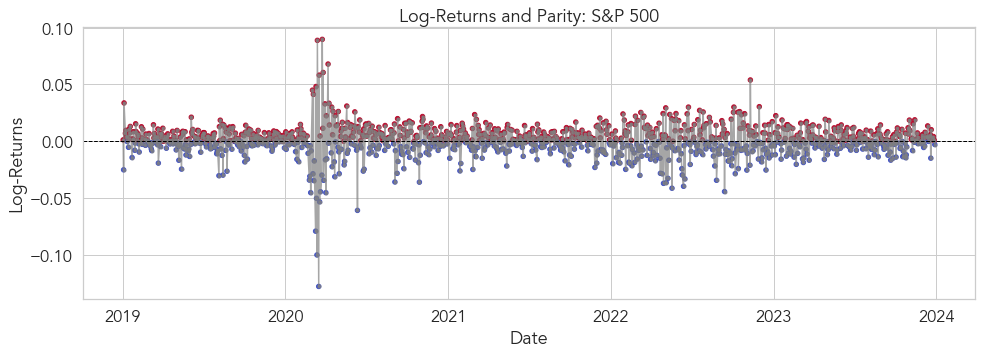

In [5]:
sample_ticker = '^GSPC'
# data = pd.read_csv(os.path.join(DATA_DIR, f'{sample_ticker}.csv'), index_col=0, parse_dates=True)
data = ec.data.stock_parity.compute_log_returns_and_parity(sample_ticker, start=INIT_DATE, end=END_DATE, save_dir=DATA_DIR)
_ = ec.data.stock_parity.plot_log_returns_and_parity(data.loc[data.index >= START_DATE], sample_ticker, 
                                                     title="Log-Returns and Parity: S&P 500", save_dir=plots_dir)

High-Volatility Threshold: 0.01181668284022239


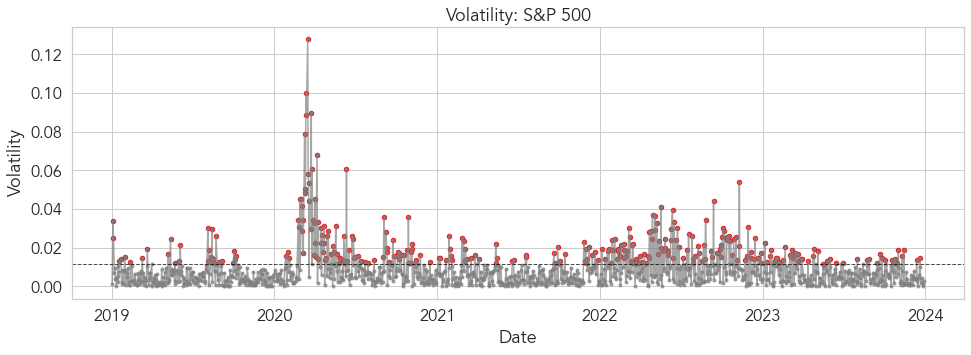

In [6]:
# compute a threshold from the first year's data and plot volatility + high-volatility days
threshold = data.loc[data.index < START_DATE, "Volatility"].quantile(HIGH_QUANTILE)
print("High-Volatility Threshold:", threshold)
_ = ec.data.stock_parity.plot_volatility(data.loc[data.index >= START_DATE], 
                                         threshold=threshold, ticker_name=sample_ticker, 
                                         title="Volatility: S&P 500", save_dir=plots_dir)

In [7]:
# compute high-volatility days
data["HighVol"] = data["Volatility"] > threshold
data["HighVol"].value_counts()

False    1156
True      353
Name: HighVol, dtype: int64

In [8]:
# plot

### Exchangeability of High-Volatility Days

In [9]:
# HPARAMS
methods = ["UI", "Conformal"]
methods_kwargs = [None, dict(jump=0.01, jumper_weights=(1/3, 1/3, 1/3))]
needs_adj = [False, True]
adjuster_kwargs = [None, dict(use_maximum=True)]
test_volatility = True

colors = [ec.PLOT_DEFAULT_COLORS[i] for i in [0, 3, 2]]  # switch out conformal (yellow) with adjusted conformal (orange)
style_order = ["Combined", "UI", "Conformal [e-lifted]"]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


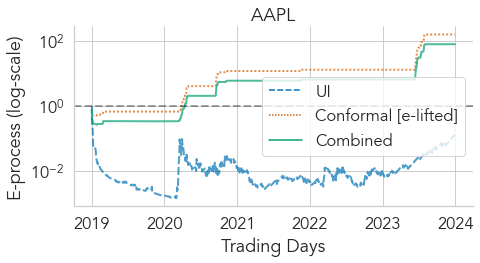

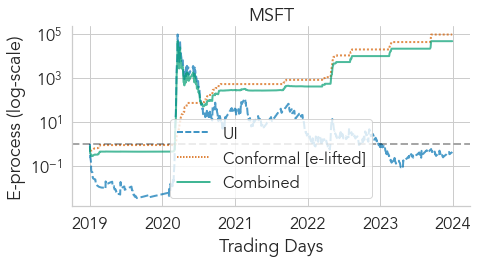

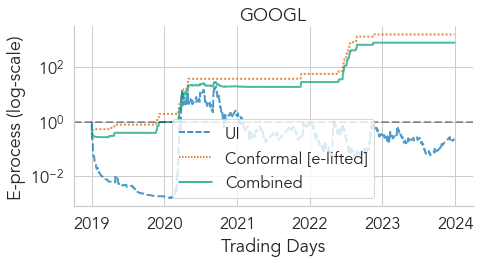

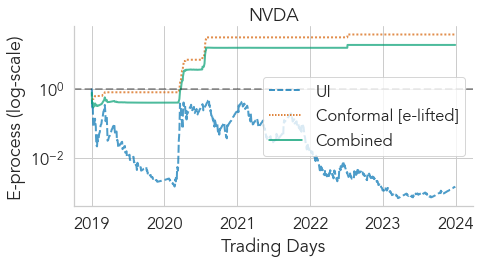

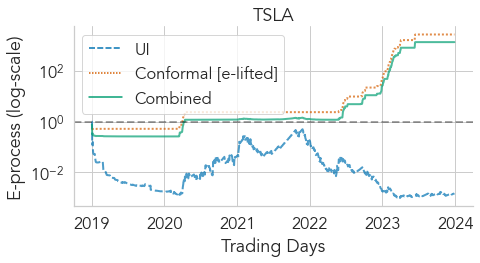

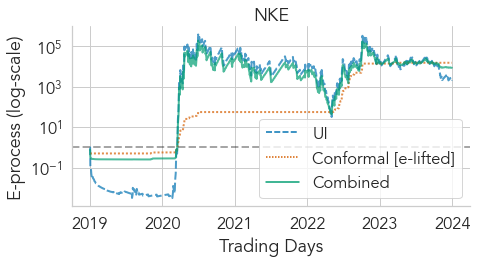

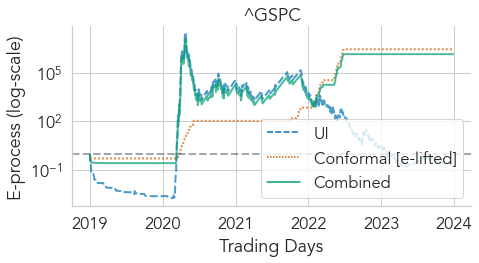

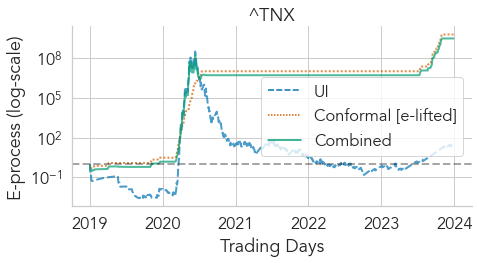

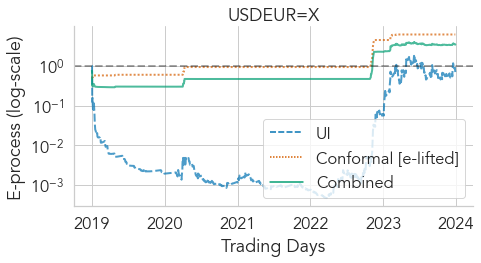

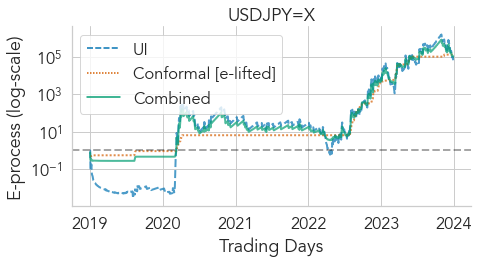

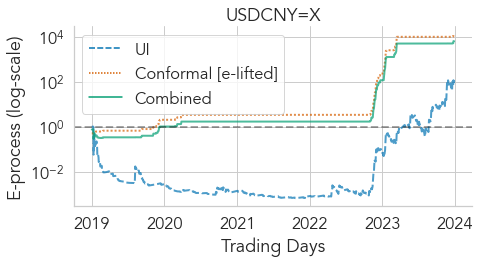

In [10]:
for ticker in tickers:
    # data = pd.read_csv(os.path.join(DATA_DIR, f'{ticker}.csv'), index_col=0, parse_dates=True)
    data = ec.data.stock_parity.compute_log_returns_and_parity(ticker, start=START_DATE, end=END_DATE, save_dir=DATA_DIR)
    # for volatility test
    # default: absolute log-returns
    data["HighVol"] = data["Volatility"] > data["Volatility"].quantile(HIGH_QUANTILE)
    # data["VolSq"] = (data["Price"] - data["Price"].shift(1)) ** 2  # absolute price difference
    # data["VolSq"] = (data["Price"] - data["Price"].shift(1)) ** 2 / data["Price"].shift(1) ** 2  # relative price difference
    # data["VolSq"] = data["LogReturns"] ** 2  # log returns squared

    eprocesses_dict, x_df = ec.combined_exch_eprocesses(
        data, 
        methods=methods,
        methods_kwargs=methods_kwargs,
        needs_adj=needs_adj,
        adjuster_kwargs=adjuster_kwargs,
        data_col="HighVol",
        rng=rng,
        return_df=False,
        )
    e_labels, e_list = zip(*eprocesses_dict.items())
    fg = ec.plot_eprocess(
        e_list, e_labels, time_index=x_df.index, 
        palette=colors, style_order=style_order, facet_kws=dict(legend_out=False),
        height=4, aspect=1.75, 
        title=ticker,
        # title=f"H0: Exchangeability of High-Volatility Days for {ticker}",
    )
    fg.ax.set_xlabel("Trading Days")
    # remove legend title
    fg._legend.set_title(None)
    fg.tight_layout()
    fg.savefig(os.path.join(plots_dir, f"EProcessHighVolatility{ticker}.pdf"))
    fg.savefig(os.path.join(plots_dir, f"EProcessHighVolatility{ticker}.png"), dpi=350)

In [11]:
# highlight_tickers = ["MSFT", "NKE", "^GSPC", "USDCNY=X"]  # TSLA
# ticker_names = ["Microsoft (MSFT)", "Nike (NKE)", "S&P 500 (GSPC)", "USD/CNY"]  # Tesla
highlight_tickers = ["^GSPC", "USDCNY=X", "MSFT", "NKE"]  # TSLA
ticker_names = ["S&P 500 (GSPC)", "US Dollar to Chinese Yen (USDCNY)", "Microsoft (MSFT)", "Nike (NKE)"]  # Tesla (TSLA)

In [12]:
highlight_df = pd.DataFrame()
for ticker, name in zip(highlight_tickers, ticker_names):
    # data = pd.read_csv(os.path.join(DATA_DIR, f'{ticker}.csv'), index_col=0, parse_dates=True)
    data = ec.data.stock_parity.compute_log_returns_and_parity(ticker, start=START_DATE, end=END_DATE, save_dir=DATA_DIR)
    # for volatility test
    # default: absolute log-returns
    data["HighVol"] = data["Volatility"] > data["Volatility"].quantile(HIGH_QUANTILE)
    # data["VolSq"] = (data["Price"] - data["Price"].shift(1)) ** 2  # absolute price difference
    # data["VolSq"] = (data["Price"] - data["Price"].shift(1)) ** 2 / data["Price"].shift(1) ** 2  # relative price difference
    # data["VolSq"] = data["LogReturns"] ** 2  # log returns squared

    eprocesses_df, x_df = ec.combined_exch_eprocesses(
        data, 
        methods=methods,
        methods_kwargs=methods_kwargs,
        needs_adj=needs_adj,
        adjuster_kwargs=adjuster_kwargs,
        data_col="HighVol",
        rng=rng,
        return_df=True,
        )
    
    # add to highlight_df
    eprocesses_df["Ticker"] = name
    eprocesses_df["Date"] = x_df.index
    highlight_df = pd.concat([highlight_df, eprocesses_df], axis=0)

highlight_df = highlight_df.melt(id_vars=["Date", "Ticker"], var_name="Method", value_name="E-Process")
highlight_df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Date,Ticker,Method,E-Process
0,2019-01-02,S&P 500 (GSPC),UI,1.000000
1,2019-01-03,S&P 500 (GSPC),UI,0.250000
2,2019-01-04,S&P 500 (GSPC),UI,0.250000
3,2019-01-07,S&P 500 (GSPC),UI,0.158203
4,2019-01-08,S&P 500 (GSPC),UI,0.074074
...,...,...,...,...
15223,2023-12-22,Nike (NKE),Combined,89803.297871
15224,2023-12-26,Nike (NKE),Combined,89610.511218
15225,2023-12-27,Nike (NKE),Combined,89649.531371
15226,2023-12-28,Nike (NKE),Combined,89690.150230


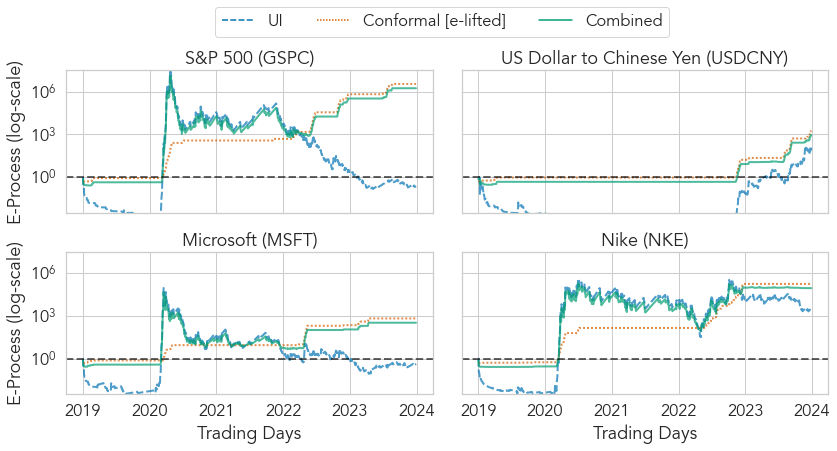

In [13]:
# plot all together in a 2x2 grid with relplot
fig, axes = plt.subplots(2, 2, figsize=(12, 6), sharex=True, sharey=True)

for i, (ticker, ax) in enumerate(zip(ticker_names, axes.flatten())):
    sns.lineplot(data=highlight_df[highlight_df["Ticker"] == ticker], 
                 x="Date", y="E-Process", hue="Method", style="Method", ax=ax, 
                 palette=colors, style_order=style_order,
                 alpha=ec.PLOT_DEFAULT_KWARGS["alpha"], linewidth=ec.PLOT_DEFAULT_KWARGS["linewidth"],
                 )
    ax.set(title=f"{ticker}", xlabel="Trading Days", ylabel="E-Process (log-scale)", yscale="log", ylim=(10 ** -2.5, 10 ** 7.5))
    ax.axhline(1, color="black", linestyle="--", linewidth=ec.PLOT_DEFAULT_KWARGS["linewidth"], alpha=0.6)
    # no individual legend
    ax.get_legend().remove()

# a combined legend at the top
fig = axes[0, 0].get_figure()
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=3, title=None, frameon=True, bbox_to_anchor=(0.525, 1.075))
# legend on the right
# fig.legend(handles, labels, loc="center right", ncol=1, title=None, frameon=False, bbox_to_anchor=(1.17, 0.5))
fig.tight_layout()
fig.savefig(os.path.join(plots_dir, f"EProcessHighVolatilityDays.pdf"), bbox_inches="tight")
fig.savefig(os.path.join(plots_dir, f"EProcessHighVolatilityDays.png"), dpi=350, bbox_inches="tight")